In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Load CIFAR-10 Dataset

### **CIFAR-10 Dataset**: It consists of 60,000 32x32 color images in 10 classes. Here, only the training set (X_train) is used, and the images are normalized to values between 0 and 1 to improve training stability.

In [7]:
# Load CIFAR-10 dataset
(X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

# Build Generator

### The **generator** creates images that resemble real data from a random noise vector (input_dim=100), also called a latent space. It uses Convolutional Transpose layers (also known as deconvolution or upsampling layers) to gradually increase the spatial dimensions and convert the input noise into a 32x32 RGB image.

### ***Dense(256 * 8 * 8)***: The noise vector is transformed into a 256-channel feature map of shape 8x8.

### ***Reshape((8, 8, 256))***: Reshapes the dense output into a 3D feature map.

### ***Conv2DTranspose***: These layers upsample the feature maps to 16x16 and 32x32. Strides of 2 are used to double the spatial dimensions.

### ***Conv2D(3)***: The output is a 32x32 image with 3 channels (RGB). Tanh activation scales the pixel values to the range [-1, 1] to match the normalized CIFAR-10 images.

In [14]:
# Generator model (DCGAN)
def build_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8 * 8 * 256, input_dim=100))  # Start from a low-dimensional space
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))  # Now this will output (16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))  # Now this will output (32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh'))  # Output will be (32, 32, 3)

    return model

generator = build_generator()
generator.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_46 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_22                  │ (None, 16, 16, 128)         │         524,416 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_47 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_23                  │ (None, 32, 32, 64)          │         131,136 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_24                  │ (None, 32, 32, 3)           │           3,075 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,315,203 (8.83 MB)

 Trainable params: 2,314,307 (8.83 MB)

 Non-trainable params: 896 (3.50 KB)

# Building the Discriminator

### The **discriminator** tries to differientiate between real and generated (fake) images. It outputs a probability between 0 (fake) and 1 (real) using a sigmoid activation.

### ***Conv2D(64)***: Applies convolution with a kernel size of 5 and a stride of 2 to downsample the 32x32 image to 16x16.

### ***LeakyReLU(0.2)***: An activation function similar to ReLU, but with a small slope for negative values (alpha = 0.2). This prevents neurons from dying during training (which can happen with ReLU).

### ***Conv2D(128)***: Further downsampling the feature map from 16x16 to 8x8.

### ***Flatten()***: Converts the 3D feature maps into a 1D vector for the dense output layer.

### ***Dense(1, sigmoid)***: Produces a single output between 0 and 1 representing whether the input image is real or fake.

In [15]:
# Discriminator model (DCGAN)
def build_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model



# Call the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 16, 16, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_49 (LeakyReLU)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 8, 8, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_50 (LeakyReLU)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 4, 4, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_51 (LeakyReLU)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 2, 2, 512)           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_52 (LeakyReLU)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,758,593 (10.52 MB)

 Trainable params: 2,758,593 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the Models

### The ***discriminator is compiled with the binary cross-entropy loss function since it performs binary classification*** (real vs. fake). The Adam optimizer is used to optimize the model.

In [16]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the function

### ***Noise Generation***: A batch of random noise vectors is generated and passed through the generator to produce fake images.

### ***Discriminator Training***: The discriminator is trained on both real and fake images. The real images are labeled as 0.9 (soft label, slightly less than 1 to prevent overconfidence), and the fake images are labeled as 0. Both are concatenated into one batch.

### ***Generator Training***: The generator tries to fool the discriminator, so it’s trained with the goal that the discriminator labels the generated images as real (1). During this phase, the discriminator's weights are frozen (discriminator.trainable = False).

### ***Loss Calculation***: After each epoch, the losses of both the discriminator (d_loss) and generator (g_loss) are printed.

In [17]:
# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)

# Image Generation Function

### This function generates images from random noise using the generator and plots them in a grid using Matplotlib. The images are rescaled from the [-1, 1] range (from the tanh activation) back to [0, 1] for viewing.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7033411860466003, acc.: 25.0%] [G loss: [array(0.6997304, dtype=float32), array(0.6997304, dtype=float32), array(0.5, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


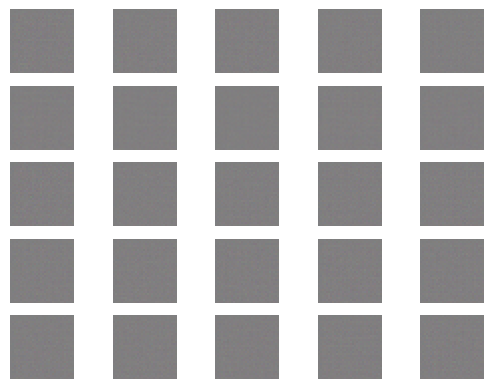

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Function to save generated images
def save_images(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_images = generator.predict(noise)
    gen_images = 0.5 * gen_images + 0.5  # Rescale from [-1, 1] to [0, 1]

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the DCGAN
train(epochs=1000, batch_size=64, save_interval=1000)

# Question 01

## **Modify the DCGAN to generate images for a specific class (e.g., cars, airplanes). Generate 10 examples of each class and analyze the quality and variety of the generated images.**

---

# Question 02

## **Apply data augmentation (random cropping, flipping, etc.) to the real CIFAR-10 images during discriminator training. Evaluate if augmentation improves the discriminator's performance and results in better-generated images.**

---

# Question 03

## **Implement the Inception Score to evaluate the quality of generated images. Train the DCGAN and compute the IS at various points (e.g., 2000, 5000, 10000 epochs). Compare the IS values with the visual quality of generated images.**

---

# Question 04

## **Add more layers to the generator and discriminator to create deeper models. Train the deeper DCGAN and observe if this complexity improves the quality of generated images.**



